In [1]:
import src.arctic as arctic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data
- provided by the Institute of Atmospheric Physics Kühlungsborn (IAP)
- ERA5: daily means at pressure levels and analysis
    - Intercomparison with Hannachi et al. (2011)
    - SWE1.tar: contains major warming diagnostics
    - SWE1.tar: elliptic diagnostics of Z10
    - SWX1.tar: extended diagnostics (reachable via VPN)
    - SWC1.tar: classfiication synthesis (reachable via VPN)

#### File structure
netCDF files are 3-dimensional data, investigated with ncdump. The .tar-files contain all output from Christoph Zülickes diagnosis, in particular:
- SWM: ASCII values in 2 files, 
    1. *cen.csv with the major warming events as identified with their central day when the wind turned from westerly to easterly along with some characteristics and
    2. *msw.csv with daily lists with wind and a marker mw for major warming
- SWE: 1 csv file
    - *d.csv: daily list of indices, including the aspect ratio of the mother vortex (ar), centrail latitude (latcent) and area (area)

In [2]:
# read data
era5_d = arctic.read_data("data/SWXClust/ERA5/e5e1_d.csv")
era5_cen = arctic.read_data("data/SWXClust/ERA5/e5m1t-cen.csv")
era5_msw = arctic.read_data("data/SWXClust/ERA5/e5m1t-msw.csv")

# remove white space from column names
arctic.no_white_space(era5_d)
arctic.no_white_space(era5_cen)
arctic.no_white_space(era5_msw)

# change string to datetime for better comparison
arctic.to_date(era5_d, 'string')
arctic.to_date(era5_cen, 'string')
arctic.to_date(era5_msw, 'string')

# merge era5 data to one big dataframe
era5_all = era5_d.merge(era5_msw, on ='string', how='left', suffixes=[None, '_msw']).merge(era5_cen, on='string', how='left', suffixes = ['_d', '_cen'])

# handling string encodings
era5_all['form'] = era5_all['form'].replace({' D' : 0, ' S': 1})
# handling NaN values and string encodings
era5_all['MW'] = pd.to_numeric(era5_all.MW.replace({'   ': 0, ' MW' : 1}))
era5_all[era5_cen.columns[-4:]] = era5_all[era5_cen.columns[-4:]].fillna(0) 

era5_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21914 entries, 0 to 21913
Data columns (total 48 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   D_d          21914 non-null  object        
 1   counter_d    21914 non-null  int64         
 2   time_d       21914 non-null  float64       
 3   string       21914 non-null  datetime64[ns]
 4   year         21914 non-null  int64         
 5   month        21914 non-null  int64         
 6   day          21914 non-null  int64         
 7   hour         21914 non-null  int64         
 8   level        21914 non-null  object        
 9   edge         21914 non-null  float64       
 10  form         21914 non-null  int64         
 11  area         21914 non-null  float64       
 12  obj_area     21914 non-null  float64       
 13  latcent      21914 non-null  float64       
 14  loncent      21914 non-null  float64       
 15  theta        21914 non-null  float64       
 16  ar  

# Meeting Note:
Um ein Tag verschoben: wie korrekter Merge? via time/string oder counter? Bisher string.

In [3]:
era5_cen

,D,num,counter,time,string,pers,Umax,Imax,Iacc
0,D,1,26,2438057.25,1963-01-27 18:00:00,10.0,-5.4,54.3,30.3
1,D,2,1080,2439111.25,1965-12-16 18:00:00,7.0,-5.1,35.9,20.2
2,D,3,1148,2439179.25,1966-02-22 18:00:00,9.0,-6.6,59.5,36.1
3,D,4,1832,2439863.25,1968-07-01 18:00:00,6.0,-4.0,24.1,15.2
4,D,5,2158,2440189.25,1968-11-28 18:00:00,3.0,-2.7,8.0,5.4
5,D,6,2558,2440589.25,1970-02-01 18:00:00,5.0,-7.5,37.6,24.6
6,D,7,2939,2440970.25,1971-01-18 18:00:00,5.0,-5.7,28.4,16.2
7,D,8,3000,2441031.25,1971-03-20 18:00:00,6.0,-3.6,21.8,14.5
8,D,9,3683,2441714.25,1973-01-31 18:00:00,11.0,-22.8,250.7,137.1
9,D,10,5122,2443153.25,1977-09-01 18:00:00,6.0,-2.0,12.2,6.5


In [4]:
era5_d[era5_d['counter'].isin(era5_cen['counter'])]

,D,counter,time,string,year,month,day,hour,level,edge,...,obj_area2,latcent2,loncent2,theta2,ar2,amp0,amp1,amp2,lon1,lon2
25,D,26,2438056.25,1963-01-26 18:00:00,1963,1,26,18,10.0,29.8,...,86652.367,65.068,33.234,0.213,1.819,29.2,0.04890,0.05430,-3.2,-2.5
1079,D,1080,2439110.25,1965-12-15 18:00:00,1965,12,15,18,10.0,29.9,...,,,,,,29.9,0.02100,0.01290,-149.7,178.1
1147,D,1148,2439178.25,1966-02-21 18:00:00,1966,2,21,18,10.0,30.1,...,,,,,,30.5,0.01760,0.01250,-175.6,178.0
1831,D,1832,2439862.25,1968-06-01 18:00:00,1968,1,6,18,10.0,30.2,...,439393.656,61.935,87.743,0.277,1.342,30.5,0.00662,0.00667,-142.8,180.0
2157,D,2158,2440188.25,1968-11-27 18:00:00,1968,11,27,18,10.0,29.9,...,,,,,,30.0,0.01830,0.01390,-163.8,178.8
2557,D,2558,2440588.25,1970-01-01 18:00:00,1970,1,1,18,10.0,30.1,...,,,,,,30.0,0.01970,0.00918,-171.8,178.4
2938,D,2939,2440969.25,1971-01-17 18:00:00,1971,1,17,18,10.0,30.1,...,376905.438,63.523,46.516,-1.526,1.078,30.4,0.01880,0.01410,-174.5,178.2
2999,D,3000,2441030.25,1971-03-19 18:00:00,1971,3,19,18,10.0,30.2,...,,,,,,30.5,0.01310,0.01020,-170.2,178.3
3682,D,3683,2441713.25,1973-01-30 18:00:00,1973,1,30,18,10.0,30.1,...,,,,,,30.2,0.01720,0.00883,-174.9,177.4
5121,D,5122,2443152.25,1977-08-01 18:00:00,1977,1,8,18,10.0,30.1,...,,,,,,30.3,0.01340,0.00840,161.9,177.7


## Reconstruction of same conditions as Hannachi et al.
- time: winterperiod (december to march) from 1958 to 2002, activity peaks in dec - jan, oscilliation period around 120-130d
    - **Note**: only data after 1963 available 
- 7 stratospheeric variables:

| temp. (lat1) | temp (lat2) |temp. (lat3) | avg. zon. wind (lat1) | avg. zon. wind (lat2) | wave-1                    | wave-2                    |
|--------------|-------------|------------------|-----------------------|-----------------------|---------------------------|---------------------------|
| Zonally averaged | Zonally averaged | Zonally averaged | Zonally averaged <br/ | Zonally averaged      | Normalised by zonal winds | Normalised by zonal winds |
| 60-70°N      | 70-80°N     | 80-90°N          | 60-70°N               | 70-80°N               | 60°N                      | 60°N                      |

- 7 pressure levels between 100 to 1hPa
- geometrical features: latitude centroid (lat), area (area), aspect ratio (AR) - kurtosis omitted due to skewness

#### Approaches
1. Hierarchical Clustering
    - Used distance: Euclidean distance
    - Distance between Cluster: Complete Linkage to avoid chain and spheroidal tendencies of single and average linkage
    - Gap statistic to find number of clusters with Poisson point process (standard)
    - SSA to deal with seasonality and its variation

|               | between points in Cluster | Different                                  |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |

In [5]:
# time constraints
era5_winter = era5_all[(era5_all['string'] < '01-01-2003') & 
                     (era5_all['month']).isin([12,1,2,3])]

era5_hannachi = era5_winter[['year', 'month', 'day', 'area', 'ar', 'latcent', 'kurtosis']]

era5_all = era5_all[['year', 'month', 'day', 'area', 'ar', 'latcent', 'kurtosis', # used features from hannachi et al.
                             'obj_area', 'theta', 'loncent', 'edge', # further geometric measures
                             'amp0', 'amp1', 'amp2', 'lon1', 'lon2', # waves
                             'u', 'MW', # major warmings
                             'pers', 'Umax', 'Iacc', 'Imax' # SSW event
                             ]]
# check for completeness
era5_hannachi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4850 entries, 0 to 14609
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      4850 non-null   int64  
 1   month     4850 non-null   int64  
 2   day       4850 non-null   int64  
 3   area      4850 non-null   float64
 4   ar        4850 non-null   float64
 5   latcent   4850 non-null   float64
 6   kurtosis  4850 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 303.1 KB


In [7]:
from sklearn.cluster import AgglomerativeClustering

In [8]:
gap_values_ar_latcent = arctic.gap_statistic(era5_hannachi[['ar', 'latcent']], k_max=10, n_replicates=15)
gap_values_hannachi = arctic.gap_statistic(era5_hannachi, k_max=10, n_replicates=15)
gap_values_ar_latcent_area = arctic.gap_statistic(era5_hannachi[['ar', 'latcent', 'area']], k_max=10, n_replicates=15)
gap_values_all = arctic.gap_statistic(era5_all, k_max=10, n_replicates=15)

elbow_values_ar_latcent = arctic.elbow_method(era5_hannachi[['ar', 'latcent']], k_max=10)
elbow_values_hannachi = arctic.elbow_method(era5_hannachi, k_max=10)
elbow_values_ar_latcent_area = arctic.elbow_method(era5_hannachi[['ar', 'latcent', 'area']], k_max=10)
elbow_values_all = arctic.elbow_method(era5_all, k_max=10)

silhouette_values_ar_latcent = arctic.silhouette_method(era5_hannachi[['ar', 'latcent']], k_max=10)
silhouette_values_hannachi = arctic.silhouette_method(era5_hannachi, k_max=10)
silhouette_values_ar_latcent_area = arctic.silhouette_method(era5_hannachi[['ar', 'latcent', 'area']], k_max=10)
silhouette_values_all = arctic.silhouette_method(era5_all, k_max=10)

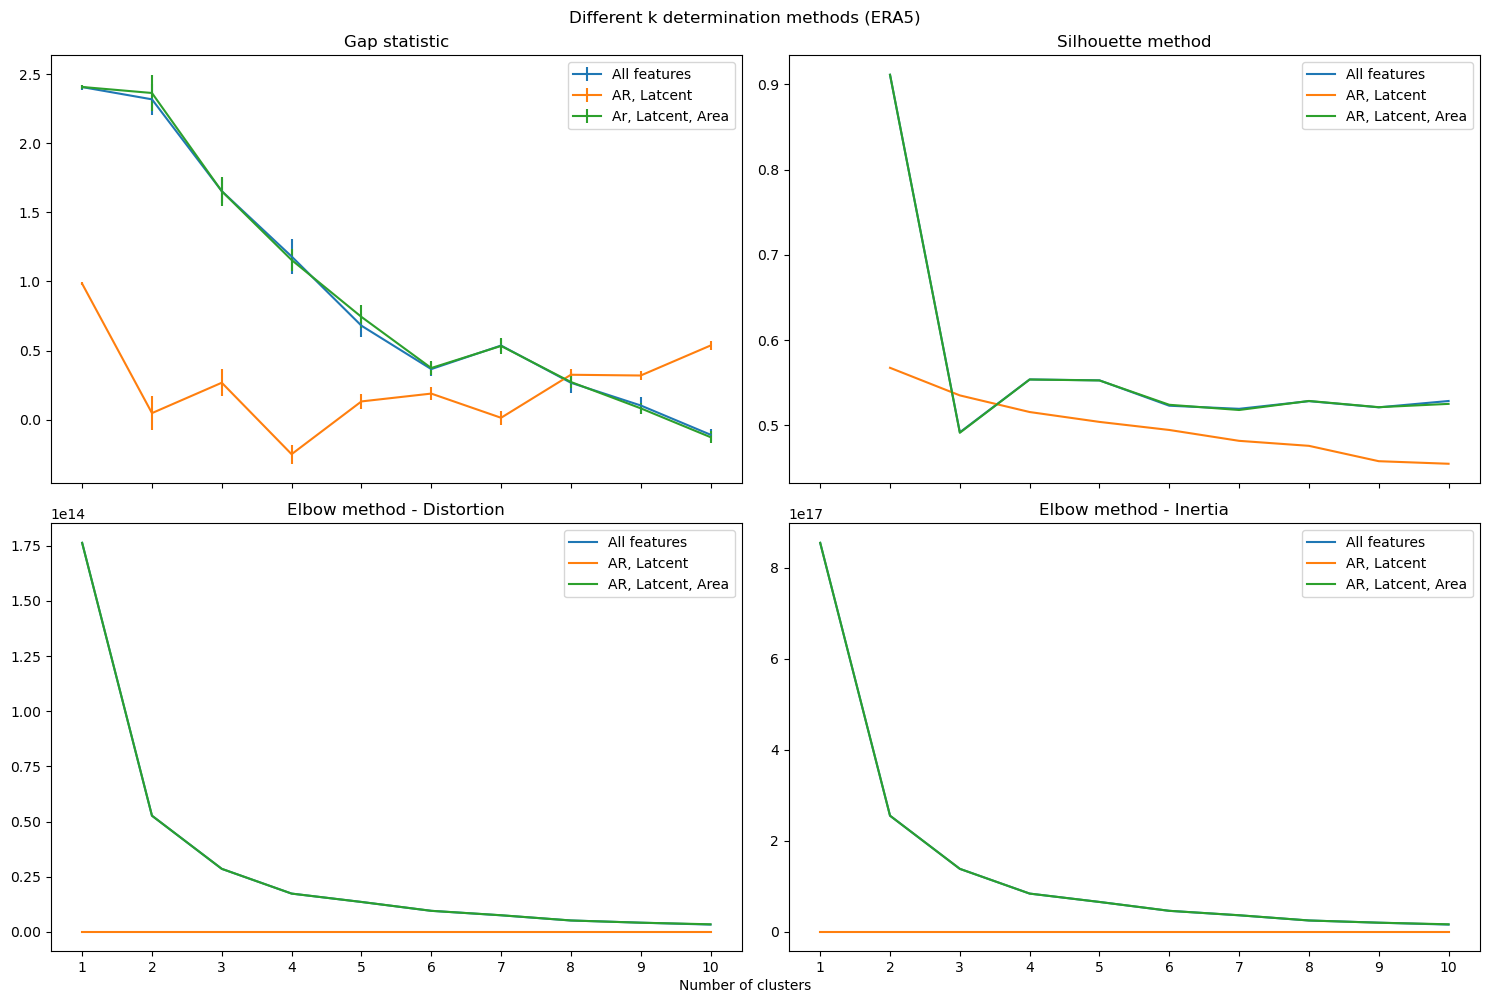

In [9]:
fig, ax = plt.subplots(2,2, figsize=(15, 10), sharex=True)
ax[0][0].errorbar(np.arange(1,11), gap_values_hannachi[:, 0], yerr=gap_values_hannachi[:, 1], label='All features')
ax[0][0].errorbar(np.arange(1,11), gap_values_ar_latcent[:, 0], yerr=gap_values_ar_latcent[:, 1], label='AR, Latcent')
ax[0][0].errorbar(np.arange(1,11), gap_values_ar_latcent_area[:, 0], yerr=gap_values_ar_latcent_area[:, 1], label='Ar, Latcent, Area')
ax[0][0].set_title('Gap statistic')
ax[0][0].legend()

ax[1][0].plot(np.arange(1,11), elbow_values_hannachi[:][0], label='All features')
ax[1][0].plot(np.arange(1,11), elbow_values_ar_latcent[:][0], label='AR, Latcent')
ax[1][0].plot(np.arange(1,11), elbow_values_ar_latcent_area[:][0], label='AR, Latcent, Area')
ax[1][0].set_title('Elbow method - Distortion')
# ax[1][0].set_yscale('log')
ax[1][0].legend()

ax[1][1].plot(np.arange(1,11), elbow_values_hannachi[:][1], label='All features')
ax[1][1].plot(np.arange(1,11), elbow_values_ar_latcent[:][1], label='AR, Latcent')
ax[1][1].plot(np.arange(1,11), elbow_values_ar_latcent_area[:][1], label='AR, Latcent, Area')
ax[1][1].set_title('Elbow method - Inertia')
# ax[1][1].set_yscale('log')
ax[1][1].legend()

ax[0][1].plot(np.arange(2,11), silhouette_values_hannachi, label='All features')
ax[0][1].plot(np.arange(2,11), silhouette_values_ar_latcent, label='AR, Latcent')
ax[0][1].plot(np.arange(2,11), silhouette_values_ar_latcent_area, label='AR, Latcent, Area')
ax[0][1].set_title('Silhouette method')
ax[0][1].legend()

plt.suptitle('Different k determination methods (ERA5)')
plt.xticks(np.arange(1, 11))
fig.text(0.5, 0, 'Number of clusters', ha='center')
plt.tight_layout()
plt.savefig('./output/Kopt_era5.png')
plt.show()


### Optimal number of clusters

In [10]:
p_h, p_2, p_3, p_all = 1,1,1,1
for k in range(0, 10):
    if p_h and (gap_values_hannachi[k][0] >= gap_values_hannachi[k+1][0] - gap_values_hannachi[k+1][1]):
        print('Gap statistic (all Hannachi): ', k+1)
        p_h=0
    if p_2 and (gap_values_ar_latcent[k][0] >= gap_values_ar_latcent[k+1][0] - gap_values_ar_latcent[k+1][1]):
        print("Gap statistic (AR, latcent): ", k+1)
        p_2 = 0
    if p_3 and (gap_values_ar_latcent_area[k][0] >= gap_values_ar_latcent_area[k+1][0] - gap_values_ar_latcent_area[k+1][1]):
        print("Gap statistic (AR, latcent, AREA): ", k+1)
        p_3=0
    if p_all and (gap_values_all[k][0] >= gap_values_all[k+1][0]-gap_values_all[k+1][0]):
        print("Gap statistic (all features): ", k+1)
        p_all=0
        
print("Silhouette method (all features): ", pd.DataFrame(silhouette_values_hannachi).idxmax()[0]+2)
print("Silhouette method (AR, latcent): ", pd.DataFrame(silhouette_values_ar_latcent).idxmax()[0]+2)
print("Silhouette method (AR, latcent, AREA): ", pd.DataFrame(silhouette_values_ar_latcent_area).idxmax()[0]+2)

Gap statistic (all Hannachi):  1
Gap statistic (AR, latcent):  1
Gap statistic (AR, latcent, AREA):  1
Gap statistic (all features):  3
Silhouette method (all features):  2
Silhouette method (AR, latcent):  2
Silhouette method (AR, latcent, AREA):  2


In [128]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN

# data sets
datasets = [era5_hannachi, 
            era5_hannachi[['ar', 'latcent']], 
            era5_hannachi[['ar', 'latcent', 'area']]]

# processing steps
N = np.arange(2, 10)
scalers = [None, StandardScaler(), MinMaxScaler()]
pca_opt = [None, PCA()]
linkages = ['complete', 'ward', 'single', 'average']
n_init_opt = ['auto', 10, 5]
dbscan_params = [{'eps': 0.3, 'min_samples': 5}, {'eps': 0.5, 'min_samples': 3}]

# dict with all pipeslines per dataset
all_pipes = {0 : [], 1 : [], 2 : []}

for idx, X_data in enumerate(datasets):
    for scaler in scalers:
        for pca in pca_opt:
            for n_clusters in N:
                # params specific to clustering method
                for linkage in linkages:
                    # Agglomerative Clustering pipeline
                    steps = []
                    if scaler: steps.append(('scaler', scaler))
                    if pca: steps.append(('pca', pca))
                    steps.append(('agglo', AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)))
                    pipe = Pipeline(steps)
                    all_pipes[idx].append(pipe)

                for n_init in n_init_opt:
                    # KMeans pipeline
                    steps = []
                    if scaler: steps.append(('scaler', scaler))
                    if pca: steps.append(('pca', pca))
                    steps.append(('kmeans', KMeans(n_clusters=n_clusters, n_init=n_init, random_state=42)))
                    pipe = Pipeline(steps)
                    all_pipes[idx].append(pipe)
                for 

            for db_params in dbscan_params:
                # DBSCAN (note: no n_clusters param)
                steps = []
                if scaler: steps.append(('scaler', scaler))
                if pca: steps.append(('pca', pca))
                steps.append(('dbscan', DBSCAN(**db_params)))
                pipe = Pipeline(steps)
                all_pipes[idx].append(pipe)

In [129]:
results = {0:[], 1:[], 2:[]}

for idx, X_data in enumerate(datasets):
    for pipe in all_pipes[idx]:
        try:
            labels = pipe.fit_predict(X_data)
            print(f"Labels predicted with {pipe}")
            # If more than 1 cluster found, calculate silhouette score
            if len(set(labels)) > 1:
                score = arctic.silhouette_score(X_data, labels)
                print("Score computed")
            else:
                score = -1  # invalid silhouette
            results[idx].append({
                'pipeline': pipe,
                'labels': labels,
                'silhouette': score
            })
        except Exception as e:
            results[idx].append({
                'pipeline': pipe,
                'labels': None,
                'silhouette': None,
                'error': str(e)
            })

Labels predicted with Pipeline(steps=[('agglo', AgglomerativeClustering(linkage='complete'))])
Score computed
Labels predicted with Pipeline(steps=[('agglo', AgglomerativeClustering())])
Score computed
Labels predicted with Pipeline(steps=[('agglo', AgglomerativeClustering(linkage='single'))])
Score computed
Labels predicted with Pipeline(steps=[('agglo', AgglomerativeClustering(linkage='average'))])
Score computed
Labels predicted with Pipeline(steps=[('kmeans',
                 KMeans(n_clusters=2, n_init='auto', random_state=42))])
Score computed
Labels predicted with Pipeline(steps=[('kmeans', KMeans(n_clusters=2, n_init=10, random_state=42))])
Score computed
Labels predicted with Pipeline(steps=[('kmeans', KMeans(n_clusters=2, n_init=5, random_state=42))])
Score computed
Labels predicted with Pipeline(steps=[('agglo',
                 AgglomerativeClustering(linkage='complete', n_clusters=3))])
Score computed
Labels predicted with Pipeline(steps=[('agglo', AgglomerativeClustering(

In [136]:
best_models = {}
for idx in results:
    valid_results = [r for r in results[idx] if r['silhouette'] is not None]
    if valid_results:
        best = max(valid_results, key=lambda r: r['silhouette'])
        best_models[idx] = best
best_models

{0: {'pipeline': Pipeline(steps=[('agglo', AgglomerativeClustering())]),
  'labels': array([0, 0, 0, ..., 0, 0, 0]),
  'silhouette': 0.9135461433025126},
 1: {'pipeline': Pipeline(steps=[('agglo', AgglomerativeClustering(linkage='average'))]),
  'labels': array([0, 0, 0, ..., 0, 0, 0]),
  'silhouette': 0.5727032317684655},
 2: {'pipeline': Pipeline(steps=[('agglo', AgglomerativeClustering())]),
  'labels': array([0, 0, 0, ..., 0, 0, 0]),
  'silhouette': 0.9135461433174131}}

In [151]:
import seaborn as sns
plot_data = []
datasets_name = ['Date, AR, Latcent, AREA, Kurtosis (all Hannachi)', 'AR, Latcent', 'AR, Latcent, AREA']

for idx in results:
    for res in results[idx]:
        pipe = res['pipeline']
        if res['silhouette'] is None:
            continue

        # Defaults
        n_clusters = None
        has_pca = False
        scaler_type = 'None'
        model_type = 'Unknown'
        model_param = ''

        for name, step in pipe.steps:
            if isinstance(step, PCA):
                has_pca = True
            elif isinstance(step, StandardScaler):
                scaler_type = 'StandardScaler'
            elif isinstance(step, MinMaxScaler):
                scaler_type = 'MinMaxScaler'
            elif isinstance(step, AgglomerativeClustering):
                model_type = 'Agglomerative'
                n_clusters = step.n_clusters
                model_param = f'linkage={step.linkage}'
            elif isinstance(step, KMeans):
                model_type = 'KMeans'
                n_clusters = step.n_clusters
                model_param = f'n_init={step.n_init}'
            # extra handling necessary, has no number of clusters as other
            elif isinstance(step, DBSCAN):
                model_type = 'DBSCAN'
                n_clusters = -1
                model_param = f'eps={step.eps}, min_samples={step.min_samples}'

        plot_data.append({
            'dataset': f'{datasets_name[idx]}',
            'n_clusters': n_clusters,
            'silhouette': res['silhouette'],
            'PCA': 'With PCA' if has_pca else 'No PCA',
            'Scaler': scaler_type,
            'Model': model_type,
            'ModelParam': model_param
        })
df_plot = pd.DataFrame(plot_data)

df_plot['ModelFull'] = df_plot['Model'].astype(str) + ' (' + df_plot['ModelParam'].astype(str) + ')'
df_plot['Prep'] = df_plot['PCA'].astype(str) + ' | ' + df_plot['Scaler'].astype(str)

df_plot = df_plot[df_plot['n_clusters'] > 0]

# Define default line styles
model_styles = {
    'Agglomerative': 'dotted',
    'KMeans': 'dashed',
    'DBSCAN': 'dashdot'
}

# Automatically map line styles from model
df_plot['LineStyle'] = df_plot['Model'].map(model_styles)

/home/hanna/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hanna/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hanna/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/hanna/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

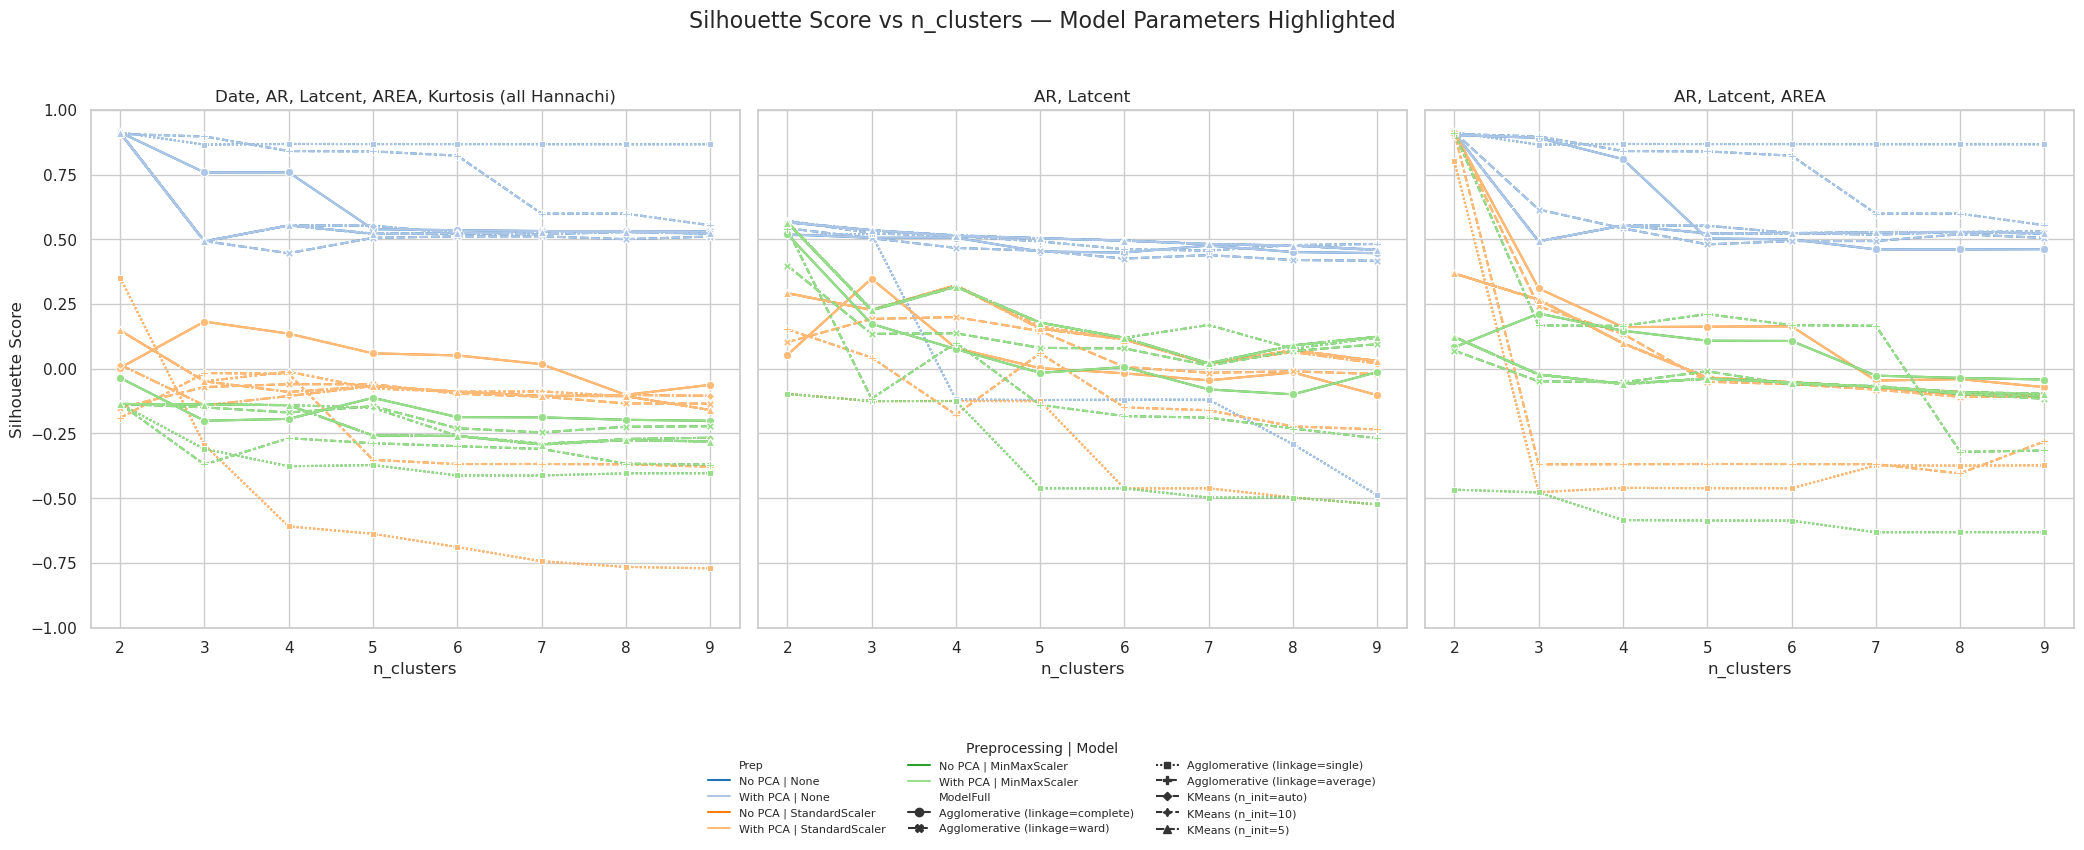

In [180]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)

for i, dataset_name in enumerate(df_plot['dataset'].unique()):
    ax = axes[i]
    df_subset = df_plot[df_plot['dataset'] == dataset_name]

    sns.lineplot(
        data=df_subset,
        x='n_clusters',
        y='silhouette',
        hue='Prep',
        style='ModelFull',
        markers=True,
        palette='tab20',
        ax=ax,
        legend=(i==0)
    )

    ax.set_title(f'{dataset_name}')
    ax.set_xlabel('n_clusters')
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(2,10))
    # ax.set_xticks(np.arange(2,5))
    if i == 0:
        ax.set_ylabel('Silhouette Score')
    else:
        ax.set_ylabel('')

    # ax.legend(title='Preprocessing + Model', fontsize=8, title_fontsize=9)
import matplotlib.lines as mlines

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='Preprocessing | Model',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),  # ⬅️ places legend just *below* the plots
    ncol=3,
    fontsize=8,
    title_fontsize=10,
    frameon=False  # Optional: cleaner look
)

axes[0].get_legend().remove()

plt.suptitle('Silhouette Score vs n_clusters — Model Parameters Highlighted', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./output/compare_models.png')
plt.show()

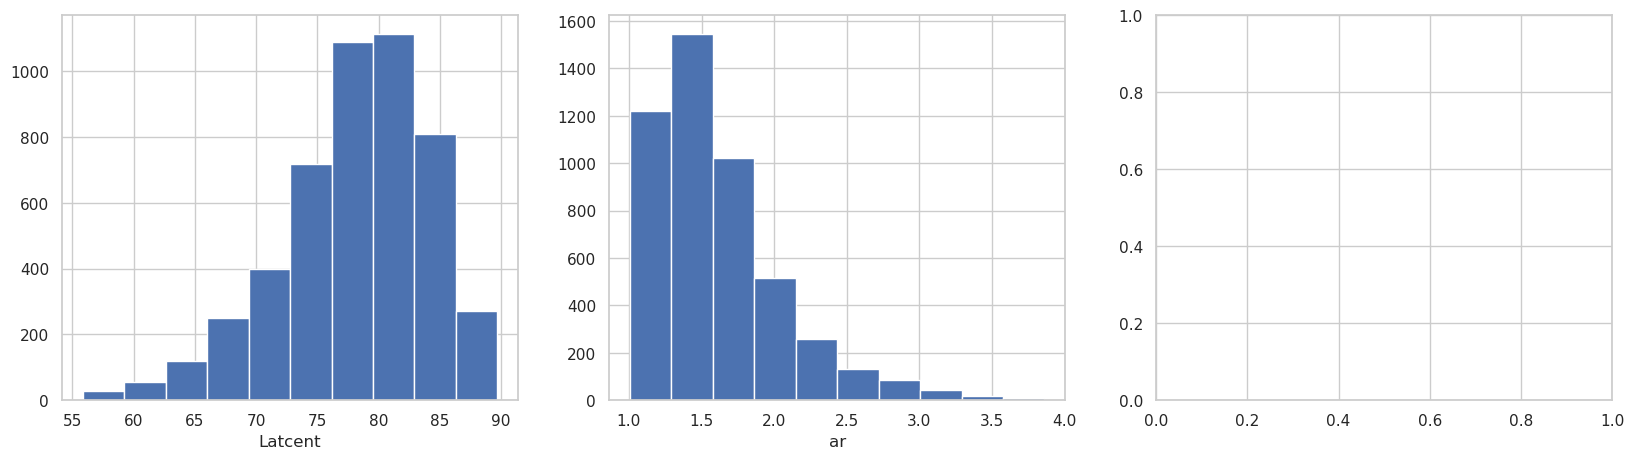

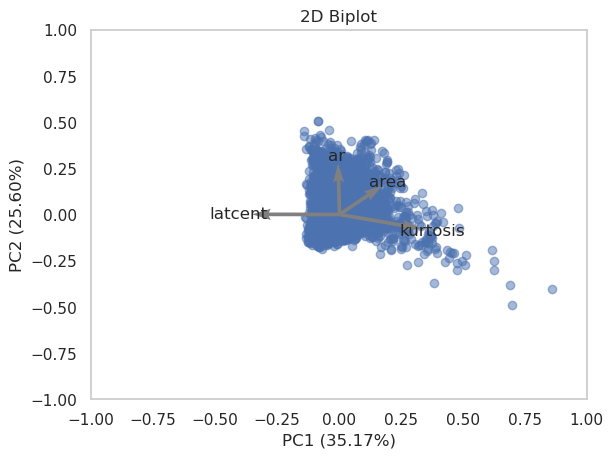

PC0    latcent
PC1         ar
PC2       area
PC3    latcent
dtype: object

In [185]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(era5_hannachi['latcent'])
ax[0].set_xlabel('Latcent')
ax[1].hist(era5_hannachi['ar'])
ax[1].set_xlabel('ar')
# ax[0].set_ylabel('AR')
# ax[1].scatter(era5_hannachi['ar'], era5_hannachi['area'])
# ax[1].set_xlabel('AR')
# ax[1].set_ylabel('Area')
# ax[2].scatter(era5_hannachi['latcent'], era5_hannachi['area'])
# ax[2].set_xlabel('Latcent')
# ax[2].set_ylabel('Area')
plt.show()

pca_3 = arctic.compute_pca(era5_hannachi[['ar', 'latcent', 'area', 'kurtosis']]) # datum weg
np.abs(pca_3.drop(['Expl_var', 'Expl_var_ratio'], axis=0)).idxmax(axis=0)

In [ ]:
era5_hannachi['hc'] = hc_label
era5_hannachi['kmeans'] = kmeans_label
# compare label with mw, c/d, s/d
corr = era5_hannachi.corr()
corr[['kmeans', 'hc']].style.background_gradient(vmin=-1, vmax=1, cmap='RdBu')

In [ ]:
print(era5_hannachi.shape)
print("Label distribution by agglomerative clustering")
for c in np.unique(hc_label):
    print(f"{c} : {era5_hannachi[era5_hannachi.hc == c].shape}")


print("Label distribution by kmeans clustering")
for c in np.unique(kmeans_label):
    print(f"{c} : {era5_hannachi[era5_hannachi.kmeans == c].shape}")


### Results from Hannachi et al.

| AR and Latc of vortex/AR, Lat, filtered vortex area | D  | U  | S  | Total |
|-----------------------------------------------------|----|----|----|-------|
| D                                                   | 7  |  3 | 0  | 10    |
| U                                                   | 4  | 80 | 2  | 86    |
| S                                                   | 1  | 0  | 3  | 4     |
| Total                                               | 12 | 83 | 5  | 100   |

Influence of different linkages:
- complete: used by Hannachi, dendogram does not indicate 3 clusters
- ward: appears similar to kmeans in distribution
- single: makes very weird Cluster with distribution 70, 4, 5027; indicates 3 Clusters
- average: makes also weird Cluster with distribution 70, 23, 5008; indicates 3 Clusters

Hierarchical cluster depends severly on **area**

In [ ]:
# Dendrogram
arctic.plot.plot_dendrogram(hc, truncate_mode='level', p=3, savefig='output/hc.png')

# Biplot
pc=5
# note "label" excluded from pca due to duplication of data.
era5_hannachi['label'] = era5_hannachi['hc']
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='3D', savefig='output/pca_era5_hc_3D.png')
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='2D', savefig='output/pca_era5_hc_2D.png')
# Radar chart
def own_agg(x):
    return x.quantile(0.75)
arctic.plot.plot_radar(era5_hannachi, label='kmeans')
arctic.plot.plot_radar(era5_hannachi, agg_func=own_agg)

# Violinplot
arctic.plot_violin(era5_hannachi)

In [ ]:
# check time integrity of clustering
print("Distribution cluster: ", era5_hannachi.hc.value_counts())
print("Distribution form: ", era5_hannachi.form.value_counts())
era5_hannachi.groupby(['year', 'hc']).count()['label']

In [ ]:
era5_hannachi.groupby(['form', 'hc']).count()['label']